<a href="https://colab.research.google.com/github/KoraySali/Dissertation_Archive/blob/main/Dissertation_Wildfire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wildfire Image Detection Dissertation**

This file will include a number of important architectures, code and technologies. A Convolutional Neural Network (CNN) model will be used for the image detection of SMOKE, NO SMOKE, FIRE, NO FIRE classification.

A chosen methodology will be followed in order to prevent confusion when writting and coding this dissertation. Various evaluation metrics will be used to evaluate the outcome of the image detection model along with a number of visualisations for readability.

For copy/version issues a Github repository has been set up in order to retain versions and prevent loss of work.

The runtime of this file will be GPU as a CPU runtime took a lot longer to perform/execute our code.

## Linking our Google Drive to our ipynb file

An important step in this file is to link it to our Google Drive allowing for usability of the drive folder for uploading and downloading various files/folders.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('/content/drive/My Drive/Dissertation')
folder = os.path.join('/content/drive/Dissertation')
!ls

Mounted at /content/drive
Dissertation_Wildfire_Detection.ipynb  main_dataset


## Importing our modules and libraries



In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import os
import cv2
import matplotlib.image as mpimg
import random
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import splitfolders
import shutil

%matplotlib inline

## Pre-processing our dataset

We first begin by checking some of the images sizes.

In [6]:
# Set the source and target directories
src_dir = "/content/drive/My Drive/Dissertation/main_dataset"
target_dir = "/content/drive/My Drive/Dissertation/target_dataset"

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Set the directories to copy
directories = ['train_smoke', 'train_fire', 'train_nofire_nosmoke']

# Copy each directory to the target directory
for dir in directories:
    src = os.path.join(src_dir, dir)
    dst = os.path.join(target_dir, dir)
    shutil.copytree(src, dst)

# Split the merged folder into training and validation sets
splitfolders.ratio(target_dir, output="/content/drive/My Drive/Dissertation/splitted_data", ratio=(0.7, 0.3))

Copying files: 24767 files [04:15, 96.78 files/s] 


In [44]:
# Image data pre-processing for the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
training_set = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Dissertation/splitted_data/train',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

# Image data pre-processing for the validation set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Dissertation/splitted_data/val',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

Found 17334 images belonging to 3 classes.
Found 7431 images belonging to 3 classes.


In [45]:
training_set.class_indices

{'train_fire': 0, 'train_nofire_nosmoke': 1, 'train_smoke': 2}

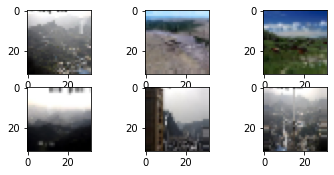

In [46]:
x, y = training_set.next()
for i in range(0, 6):
    plt.subplot(330 + 1 + i)
    plt.imshow(x[i])
plt.show()

In [47]:
# Access a batch of images and labels
images, labels = next(iter(training_set))

# Print the shape of images
print("Shape of images:", images.shape)

# Verify the labels
print("Class indices:", training_set.class_indices)
print("Labels:", labels)

Shape of images: (32, 32, 32, 3)
Class indices: {'train_fire': 0, 'train_nofire_nosmoke': 1, 'train_smoke': 2}
Labels: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [58]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(labels, num_classes=3)

In [59]:
CNN_base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
CNN_base_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.RMSprop(), metrics=["accuracy"])

In [60]:
history_base = CNN_base_model.fit(x=training_set, epochs=10, batch_size=64, validation_data=test_set)

Epoch 1/10


InvalidArgumentError: ignored

(276, 718, 4)


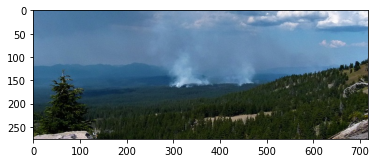

In [34]:
imgpath=r'merged_train_data/11.png'
img=plt.imread(imgpath)
print (img.shape)
imshow(img)

**We label and append the filepaths for each folder of images**

In [4]:
filepaths=[]
labels=[]
smoke_dir=r'main_dataset/train_fire'
fire_dir=r'main_dataset/train_smoke'
non_firesmoke_dir=r'main_dataset/train_nofire_nosmoke'
for d in [smoke_dir, fire_dir, non_firesmoke_dir]:
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join(d,f)
        filepaths.append(fpath)
        if d== smoke_dir:
            labels.append('smoke')
        if d== fire_dir:
            labels.append('fire')
        if d== non_firesmoke_dir:
            labels.append('nosmokefire')
            
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  24767    labels:  24767


In [ ]:
X = np.array(filepaths)
y = np.array(labels)

## Pre-processing the images

Here it is important to normalise the pixels and resize the images to all the same size to make it easier for the model to use the imagery.